# Coursework 3: Part A - RNNs

#### Instructions

Please submit on CATe a zip file named *CW3_RNNs.zip* containing a version of this notebook containing your answers. Write your answers in the cells below each question.


#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Thursday 5th March, 2020**

## Recurrent models coursework

This coursework is separated into a coding and a theory component.

For the first part, you will use the Google Speech Commands v0.02 subset that you used in the tutorial part: http://www.doc.ic.ac.uk/~pam213/co460_files/ 

### Part 1 - Coding (70%)
In this part you will have to:

#### Part 1.1 (20%)

Implement the LSTM RNN cell.

#### Part 1.2 (30%)

- Modify the RNNModel class, such that it is a Bidirectional RNN.
- Compare vanilla RNN, GRU, LSTM, and bidirectional VS unidirectional RNNs and report their performance with respect to accuracy and time cost.

#### Part 1.3 (20%)

Then for your best model you will perform some improvements:
- In terms of architecture optimisation (number of layers, hidden state dimension)
- Better utilisation of the hidden state sequence output by the RNN, for classification.
- Report the improvements you achieved, as well as an explanation for why they worked.

### Part 2 - Theory (30%)

Here you will answer some theoretical questions about RNN training, and CTC -- no detailed proofs and no programming.

### Part 1: Coding

### Dataset

We will be using the Google [*Speech Commands*](https://www.tensorflow.org/tutorials/sequences/audio_recognition) v0.02 [1] dataset.

[1] Warden, P. (2018). [Speech commands: A dataset for limited-vocabulary speech recognition](https://arxiv.org/abs/1804.03209). *arXiv preprint arXiv:1804.03209.*

For the first part, you will use the Google Speech Commands v0.02 subset that you used in the tutorial part: http://www.doc.ic.ac.uk/~pam213/co460_files/ 

Set-up code and imports

In [0]:
import math
import os
from collections import defaultdict

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np
from scipy.io.wavfile import read
import librosa
from matplotlib import pyplot as plt

cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

## Download the speech data and extract it to /data directory

In [0]:
os.system('wget https://www.doc.ic.ac.uk/~pam213/co460_files/data_speech_commands_v0.02.zip	')
os.system('mkdir data_speech_commands_v0.02')
os.system('unzip data_speech_commands_v0.02.zip -d data_speech_commands_v0.02')

256

In [0]:
os.system('mkdir data')
os.system('mv data_speech_commands_v0.02 data')

0

Data provider class definition.

Here you can give different configuration to the [mfcc function](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html). Additional keyword arguments are defined in the [melspectrogram function](https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html#librosa.feature.melspectrogram).

One may additionally consider standardising the samples (remove mean, divide by std) or performing data augmentation, e.g., by adding low variance white or noise.

In [0]:
class SpeechCommandsDataset(Dataset):
    """Google Speech Commands dataset."""

    def __init__(self, root_dir, split):
        """
        Args:
            root_dir (string): Directory with all the data files.
            split    (string): In ["train", "valid", "test"].
        """
        self.root_dir = root_dir
        self.split = split

        self.number_of_classes = len(self.get_classes())

        self.class_to_file = defaultdict(list)

        self.valid_filenames = self.get_valid_filenames()
        self.test_filenames = self.get_test_filenames()

        for c in self.get_classes():
            file_name_list = sorted(os.listdir(self.root_dir + "/data_speech_commands_v0.02/" + c))
            for filename in file_name_list:
                if split == "train":
                    if (filename not in self.valid_filenames[c]) and (filename not in self.test_filenames[c]):
                        self.class_to_file[c].append(filename)
                elif split == "valid":
                    if filename in self.valid_filenames[c]:
                        self.class_to_file[c].append(filename)
                elif split == "test":
                    if filename in self.test_filenames[c]:
                        self.class_to_file[c].append(filename)
                else:
                    raise ValueError("Invalid split name.")

        self.filepath_list = list()
        self.label_list = list()
        for cc, c in enumerate(self.get_classes()):
            f_extension = sorted(list(self.class_to_file[c]))
            l_extension = [cc for i in f_extension]
            f_extension = [self.root_dir + "/data_speech_commands_v0.02/" + c + "/" + filename for filename in f_extension]
            self.filepath_list.extend(f_extension)
            self.label_list.extend(l_extension)
        self.number_of_samples = len(self.filepath_list)

    def __len__(self):
        return self.number_of_samples

    def __getitem__(self, idx):
        sample = np.zeros((16000, ), dtype=np.float32)

        sample_file = self.filepath_list[idx]

        sample_from_file = read(sample_file)[1]
        sample[:sample_from_file.size] = sample_from_file
        sample = sample.reshape((16000, ))
        
        ########################################################################
        ## YOU MAY CONFIGURE HERE.
        ########################################################################
        sample = librosa.feature.mfcc(y=sample, sr=16000, hop_length=512, n_fft=2048).transpose().astype(np.float32)
        ########################################################################
        ## DO NOT CONFIGURE BEYOND HERE.
        ########################################################################
        
        label = self.label_list[idx]

        return sample, label

    def get_classes(self):
        return ['one', 'two', 'three']

    def get_valid_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "/data_speech_commands_v0.02/validation_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

    def get_test_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "/data_speech_commands_v0.02/testing_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

Load Dataset - you may vary batch size.

In [0]:
## MAKE SURE THIS POINTS INSIDE THE DATASET FOLDER.
dataset_folder = "data" # this should change depending on where you have stored the data files

train_dataset = SpeechCommandsDataset(dataset_folder,
                                      "train")
valid_dataset = SpeechCommandsDataset(dataset_folder,
                                      "valid")

test_dataset = SpeechCommandsDataset(dataset_folder,
                                     "test")

## YOU MAY CHANGE THE BATCH SIZE.
batch_size = 100


num_epochs = 5
valid_every_n_steps = 20
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [0]:
## test code for viewing the size of inputs
# audio, labels =  next(iter(train_loader))
# print(audio.shape)
# print(labels.shape)

## Part 1.1 (20%)

Finalise the LSTM cell (you can base your code on that of the GRU cell).

You are allowed to use nn.Linear.

In [0]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        self.W_g_x = nn.Linear(input_size, hidden_size, bias = bias)
        self.W_g_h = nn.Linear(hidden_size, hidden_size, bias = bias)
        self.W_i_x = nn.Linear(input_size, hidden_size, bias = bias)
        self.W_i_h = nn.Linear(hidden_size, hidden_size, bias = bias)
        self.W_f_x = nn.Linear(input_size, hidden_size, bias = bias)
        self.W_f_h = nn.Linear(hidden_size, hidden_size, bias = bias)
        self.W_o_x = nn.Linear(input_size, hidden_size, bias = bias)
        self.W_o_h = nn.Linear(hidden_size, hidden_size, bias = bias)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            hx = (hx, hx)
        elif type(hx) is not tuple:
            hx = (hx, hx)
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        
        # spread h_x into c_t_minus_1, h_t_minus_1
        h_t_minus_1, c_t_minus_1 = hx 
        # Now compute the control, forget, and other gates
        g_t = torch.tanh(self.W_g_x(input)+self.W_g_h(h_t_minus_1))
        i_t = torch.sigmoid(self.W_i_x(input)+self.W_i_h(h_t_minus_1))
        f_t = torch.sigmoid(self.W_f_x(input)+self.W_f_h(h_t_minus_1))
        o_t = torch.sigmoid(self.W_o_x(input)+self.W_o_h(h_t_minus_1))
        # Now compute the outputs
        cy = f_t*c_t_minus_1 + i_t*g_t 
        hy = o_t*torch.tanh(cy)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        return (hy, cy)

class BasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(BasicRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        if self.nonlinearity not in ["tanh", "relu"]:
            raise ValueError("Invalid nonlinearity selected for RNN.")

        self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

            
    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        wy = self.x2h(input) + self.h2h(hx)
        if self.nonlinearity == 'tanh':
          hy = torch.tanh(wy)
        else:
          hy = torch.relu(wy)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
            
        return hy

    
    
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        self.W_z_x = nn.Linear(input_size, hidden_size, bias = bias)
        self.W_z_h = nn.Linear(hidden_size, hidden_size, bias = bias)
        self.W_r_x = nn.Linear(input_size, hidden_size, bias = bias)
        self.W_r_h = nn.Linear(hidden_size, hidden_size, bias = bias)
        self.W_g_x = nn.Linear(input_size, hidden_size, bias = bias)
        self.W_g_h = nn.Linear(hidden_size, hidden_size, bias = bias)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        # Calculate the internal variables
        z_t = torch.sigmoid(self.W_z_x(input) + self.W_z_h(hx))
        r_t = torch.sigmoid(self.W_r_x(input) + self.W_r_h(hx))
        g_t = torch.tanh(self.W_g_x(input) + self.W_g_h(r_t*hx))
        # Compute the output
        hy = z_t*hx + (1-z_t)*g_t
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        return hy

In [0]:
class RNNModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(RNNModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        
        if mode == 'LSTM':
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
            self.rnn_cell_list.append(LSTMCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))          
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################


        elif mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")


        self.att_fc = nn.Linear(self.hidden_size, 1)
        self.fc = nn.Linear(self.hidden_size, self.output_size)

        
    def forward(self, input, hx=None):
        if hx is None:
            if torch.cuda.is_available():
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            else:
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            # replicate h0 if mode is LSTM (self added code)

        else:
             h0 = hx

        outs = []

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        # input size is something like: [100, 32, 20] ([batch_size, seq_dim, input_dim])
        # output size should be : [100] ([batch_size])
        h_t_minus_1 = [h0_element for h0_element in h0]
        for seq in range(input.size(1)):
          in_ = input[:,seq, :]
          h_t = []
          for layer, hx in zip(self.rnn_cell_list, h_t_minus_1):
            hy = layer(in_, hx)
            in_ = hy 
            if self.mode == 'LSTM':
              in_, _ = hy
            # stack hy for later use
            h_t.append(hy)
          h_t_minus_1 = h_t
          outs.append(in_)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = outs[-1].squeeze() # Related to Part 1.3.

        out = self.fc(out)
        
        
        return out
    

class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        # Not so sure if this is the right implementation
        self.rnn_cell_rev_list = nn.ModuleList()
        if mode == 'LSTM':
            self.rnn_cell_list.append(LSTMCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))          

            self.rnn_cell_rev_list.append(LSTMCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_rev_list.append(LSTMCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias)) 
        elif mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))          

            self.rnn_cell_rev_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_rev_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))
                
            self.rnn_cell_rev_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_rev_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            self.rnn_cell_rev_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_rev_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")


        self.att_fc = nn.Linear(self.hidden_size, 1)
        self.fc = nn.Linear(self.hidden_size*2, self.output_size)  
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        
    def forward(self, input, hx=None):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            
        if torch.cuda.is_available():
            hT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
        else:
            hT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            
        # self added code, Check if mode is LSTM or if hx is not None
        if hx is not None:
          h0, hT = hx 

        outs = []
        outs_rev = []
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        h_t_minus_1 = h0
        for seq in range(input.size(1)):
          in_ = input[:,-seq,:]
          h_t = []
          for layer, hx in zip(self.rnn_cell_list, h_t_minus_1):
            hy = layer(in_, hx)
            in_ = hy 
            if self.mode == 'LSTM':
              in_, _ = hy
            # stack hy for later use
            h_t.append(hy)
          h_t_minus_1 = h_t
          outs.append(in_)
        # Now run the reverse loop
        h_t_minus_1 = hT
        for seq in range(input.size(1)):
          in_ = input[:,-seq,:]
          h_t = []
          for layer, hx in zip(self.rnn_cell_rev_list, h_t_minus_1):
            hy = layer(in_, hx)
            in_ = hy 
            if self.mode == 'LSTM':
              in_, _ = hy
            # stack hy for later use
            h_t.append(hy)
          h_t_minus_1 = h_t
          outs_rev.append(in_)        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = outs[-1].squeeze()  # Related to question 10.
        out_rev = outs_rev[0].squeeze()
        out = torch.cat((out, out_rev), 1)
        out = self.fc(out)
        return out


## Part 1.2 (30%)

In the following, experiment with different RNN architectures (RNN cell types, number of layers, hidden state dimensionality, MFCC configuration, unidirectional VS bidirectional) and report the accuracy (pay also attention to the training and validation cost), as well as training time. 

* What are your justifications for these results?

* On the notebook, leave the execution of your best model.

In the table below we present some results of different architectures. We can see a better improvement using bidirectional RNN when we have simpler architectures with not-so-good performance. Generally speaking, GRU and LSTM works significantly better than vanilla RNNs, also, the larger the structure, the better performance it generally reaches.

| Architecture  | Hidden Dimension| Num of Layers|T-Accuracy for 5 Epochs(%)|Training Time for 5 Epochs(s)|
| ------------- |:---------------:|:------------:|:--------:| ------------------------:|
| RNN_RELU      |8                |4             |33|753|
| RNN_RELU(Bidirectional)| 8             | 4         |65|777|
| RNN_TANH      |8|2|33|817|
| RNN_TANH(Bidirectional)|8|2|60|709|
| GRU           | 8             | 1         |60|710|
| GRU           | 8             | 2         |86|864|
| GRU           | 32            | 4         |95|1531|
|LSTM           | 8             | 1         |36|788|
|LSTM           | 8             | 2         |79|842|
|LSTM           | 32             | 4         |95|1695|
| GRU(Bidirectional)|128         | 4         |96|very long|


For basic RNN cell, GRU, and LSTMs we can all get improved performance by increasing the hidden dimension. Adding the number of layers also help, but if the number of layers is too much, the performance actually decreases a little. This result may be due to the vanishing gradients or exploding gradients when the gradient propagation path is too long.

With basic RNN cell, we can achieve about 60% accuracy with properly selected hidden dimension and layer number, LSTM and GRU performs much better, both can achieve about 96% accuracy. Below we leave the GRU implementation because it learns faster and the learning process is more stable than LSTM. 

LSTM and GRU performs better than the basic RNN model since both of them implements some sort of forget and update mechanism in its structure, intuitively this allows the model to decide which information to remember or forget. In training, this design helps cope with the gradient vanishing and exploding problem. Both LSTM and GRU achieves good performance given our task, however, since GRU uses less parameters in its model, it takes much shorter time to train compared to LSTM. Using Bidirectional model does seem to improve the model, but not significantly.


 The following results are obtained with default hyperparameters except for the learning rate, which is set to 0.001 (default: 0.01). We found that this significantly helped the training process.

In [0]:
# Parts of experiment code based on: https://github.com/emadRad/lstm-gru-pytorch

seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

## YOU MAY CONFIGURE THESE.
hidden_dim = 128
layer_dim = 4
bias = True

#model = RNNModel("LSTM", input_dim, hidden_dim, layer_dim, bias, output_dim)
model = BidirRecurrentModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim)

if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

## YOU MAY CONFIGURE THESE.
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0
for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(audio)

        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % valid_every_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct / total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                t_accuracy = 100 * correct / total
                reported_t_accuracy = t_accuracy

            print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))



Iteration: 20. Loss: 0.8177092671394348. V-Accuracy: 67  T-Accuracy: 67
Iteration: 40. Loss: 0.5248502492904663. V-Accuracy: 81  T-Accuracy: 81
Iteration: 60. Loss: 0.4475664794445038. V-Accuracy: 86  T-Accuracy: 85
Iteration: 80. Loss: 0.2768057584762573. V-Accuracy: 89  T-Accuracy: 89
Iteration: 100. Loss: 0.3479447662830353. V-Accuracy: 90  T-Accuracy: 90
Iteration: 120. Loss: 0.25785061717033386. V-Accuracy: 91  T-Accuracy: 91
Iteration: 140. Loss: 0.09983363002538681. V-Accuracy: 92  T-Accuracy: 92
Iteration: 160. Loss: 0.1175779178738594. V-Accuracy: 94  T-Accuracy: 93
Iteration: 180. Loss: 0.22920922935009003. V-Accuracy: 94  T-Accuracy: 94
Iteration: 200. Loss: 0.1086614802479744. V-Accuracy: 95  T-Accuracy: 94
Iteration: 220. Loss: 0.1191321536898613. V-Accuracy: 95  T-Accuracy: 94
Iteration: 240. Loss: 0.12885703146457672. V-Accuracy: 95  T-Accuracy: 95
Iteration: 260. Loss: 0.10223667323589325. V-Accuracy: 95  T-Accuracy: 95
Iteration: 280. Loss: 0.06449076533317566. V-Accur

## Part 1.3 (20%)

RNN hidden state. In the code above in the RNNModel and BidirRecurrentModel, we utilise the final hidden state extracted by the model in order to make the final pass through a feed-forward layer towards a final prediction.

a) Can you think of reasons this might not be the best choice? Please write down two variations that could possibly yield better result.

b) Experiment with such alternative approaches in the code below in order to achieve a better result and report it below.

* Your answer here. \
Using the final hidden state may not be the best solution since it is possible that the best features may be outputed before the last time sequence ends. For example, suppose in the time sequence, the voice 'one' occurred at the start and the time sequence ended with silence, then the final hidden state may not be the best one for us to predict the results. \
Here we use two strategies to try to fix this problem, the first method is that we can average all hidden states before feeding it into the fully connected network, this puts equal weights to the states at each timestep. The second method is to perform max pooling and find the max value along the time-axis. We implement both in the following cell.

To see the improvements of our method, we use a simple network and compare the improvement in the following table.

Model: RNN_TANH(Bidirectional), hidden dimension: 32, number of layers: 1 

| Method  | Loss for 5 Epochs|T-Accuracy for 5 Epochs(%)|Training Time for 5 Epochs(s)|
| ------------- |:---------------:|:------------:| ------------------------:|
| Default Method|1.109|37|720|
| Average|0.640|78|816|
| Max Pool|0.520|80|799|

We can see both implementation improves the test accuracy. With the best model we obtained in Part1.2, the improvement is not a lot, however, using the max pooling method, we can see that the accuracy reaches 93% after 60 iterations. This means that it learns significantly faster than the naive implementation. If we are dealing with a more complex problem, we can anticipate that the performance difference between max pooling and the original method be much greater.

In [0]:
class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size, out_method = 'default'):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        if out_method == 'default' or out_method == 'max_pool' or out_method == 'average':
          self.out_method = out_method
        else:
          raise ValueError("Invalid output_method selected.")
        self.rnn_cell_list = nn.ModuleList()
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        # Not so sure if this is the right implementation
        self.rnn_cell_rev_list = nn.ModuleList()
        if mode == 'LSTM':
            self.rnn_cell_list.append(LSTMCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))          

            self.rnn_cell_rev_list.append(LSTMCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_rev_list.append(LSTMCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias)) 
        elif mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))          

            self.rnn_cell_rev_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_rev_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))
                
            self.rnn_cell_rev_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_rev_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            self.rnn_cell_rev_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_rev_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")


        self.att_fc = nn.Linear(self.hidden_size, 1)
        self.fc = nn.Linear(self.hidden_size*2, self.output_size)  
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        
    def forward(self, input, hx=None):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            
        if torch.cuda.is_available():
            hT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
        else:
            hT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            
        # self added code, Check if mode is LSTM or if hx is not None
        if hx is not None:
          h0, hT = hx 

        outs = []
        outs_rev = []
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        h_t_minus_1 = h0
        for seq in range(input.size(1)):
          in_ = input[:,-seq,:]
          h_t = []
          for layer, hx in zip(self.rnn_cell_list, h_t_minus_1):
            hy = layer(in_, hx)
            in_ = hy 
            if self.mode == 'LSTM':
              in_, _ = hy
            # stack hy for later use
            h_t.append(hy)
          h_t_minus_1 = h_t
          outs.append(in_)
        # Now run the reverse loop
        h_t_minus_1 = hT
        for seq in range(input.size(1)):
          in_ = input[:,-seq,:]
          h_t = []
          for layer, hx in zip(self.rnn_cell_rev_list, h_t_minus_1):
            hy = layer(in_, hx)
            in_ = hy 
            if self.mode == 'LSTM':
              in_, _ = hy
            # stack hy for later use
            h_t.append(hy)
          h_t_minus_1 = h_t
          outs_rev.append(in_)        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        if self.out_method == 'default':
          out = outs[-1].squeeze()  # Related to question 10.
          out_rev = outs_rev[0].squeeze()
          out = torch.cat((out, out_rev), 1)
          out = self.fc(out)
        elif self.out_method == 'average':
          outs = torch.cat([out.unsqueeze(dim = 0) for out in outs])
          out = torch.mean(outs, dim = 0)
          outs_rev = torch.cat([out.unsqueeze(dim = 0) for out in outs_rev])
          out_rev = torch.mean(outs_rev, dim = 0)
        elif self.out_method == 'max_pool':
          outs = torch.cat([out.unsqueeze(dim = 0) for out in outs])
          out,_ = torch.max(outs, dim = 0)
          outs_rev = torch.cat([out.unsqueeze(dim = 0) for out in outs_rev])
          out_rev,_ = torch.max(outs_rev, dim = 0)     
        out = torch.cat((out, out_rev), 1)
        out = self.fc(out)
        return out

In [0]:
# Parts of experiment code based on: https://github.com/emadRad/lstm-gru-pytorch

# Add the model that has got the best results for you after after Part 1.2 and Part 1.3

seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

## YOU MAY CONFIGURE THESE.
hidden_dim = 128
layer_dim = 4
bias = True

# model = RNNModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim)
model = BidirRecurrentModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim, out_method = 'average')
print('Using the average method for the last layer')

if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

## YOU MAY CONFIGURE THESE.
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0
for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(audio)

        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % valid_every_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct / total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                t_accuracy = 100 * correct / total
                reported_t_accuracy = t_accuracy

            print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))



Using the average method for the last layer
Iteration: 20. Loss: 0.9877774119377136. V-Accuracy: 64  T-Accuracy: 66
Iteration: 40. Loss: 0.6809840202331543. V-Accuracy: 66  T-Accuracy: 68
Iteration: 60. Loss: 0.5313496589660645. V-Accuracy: 78  T-Accuracy: 79
Iteration: 80. Loss: 0.26688405871391296. V-Accuracy: 88  T-Accuracy: 88
Iteration: 100. Loss: 0.20744523406028748. V-Accuracy: 93  T-Accuracy: 92
Iteration: 120. Loss: 0.17008712887763977. V-Accuracy: 93  T-Accuracy: 93
Iteration: 140. Loss: 0.154689759016037. V-Accuracy: 93  T-Accuracy: 93
Iteration: 160. Loss: 0.13720938563346863. V-Accuracy: 94  T-Accuracy: 95
Iteration: 180. Loss: 0.20639042556285858. V-Accuracy: 94  T-Accuracy: 94
Iteration: 200. Loss: 0.1984833925962448. V-Accuracy: 95  T-Accuracy: 95
Iteration: 220. Loss: 0.16077476739883423. V-Accuracy: 94  T-Accuracy: 95
Iteration: 240. Loss: 0.11886243522167206. V-Accuracy: 96  T-Accuracy: 95
Iteration: 260. Loss: 0.0891822800040245. V-Accuracy: 94  T-Accuracy: 95
Itera

In [0]:
# Parts of experiment code based on: https://github.com/emadRad/lstm-gru-pytorch

# Add the model that has got the best results for you after after Part 1.2 and Part 1.3

seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

## YOU MAY CONFIGURE THESE.
hidden_dim = 128
layer_dim = 4
bias = True

# model = RNNModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim)
model = BidirRecurrentModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim, out_method = 'max_pool')
print('Using the max_pool for the last layer')

if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

## YOU MAY CONFIGURE THESE.
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0
for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(audio)

        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % valid_every_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct / total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                t_accuracy = 100 * correct / total
                reported_t_accuracy = t_accuracy

            print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))



Using the max_pool for the last layer
Iteration: 20. Loss: 0.720053493976593. V-Accuracy: 69  T-Accuracy: 68
Iteration: 40. Loss: 0.29662972688674927. V-Accuracy: 89  T-Accuracy: 89
Iteration: 60. Loss: 0.17364339530467987. V-Accuracy: 92  T-Accuracy: 93
Iteration: 80. Loss: 0.15404614806175232. V-Accuracy: 95  T-Accuracy: 94
Iteration: 100. Loss: 0.059834908694028854. V-Accuracy: 94  T-Accuracy: 94
Iteration: 120. Loss: 0.07953636348247528. V-Accuracy: 96  T-Accuracy: 96
Iteration: 140. Loss: 0.1369199901819229. V-Accuracy: 95  T-Accuracy: 96
Iteration: 160. Loss: 0.14035339653491974. V-Accuracy: 94  T-Accuracy: 96
Iteration: 180. Loss: 0.08958039432764053. V-Accuracy: 96  T-Accuracy: 95
Iteration: 200. Loss: 0.0821862667798996. V-Accuracy: 96  T-Accuracy: 96
Iteration: 220. Loss: 0.14322425425052643. V-Accuracy: 95  T-Accuracy: 96
Iteration: 240. Loss: 0.06699373573064804. V-Accuracy: 96  T-Accuracy: 96
Iteration: 260. Loss: 0.06072530150413513. V-Accuracy: 96  T-Accuracy: 96
Iterati

## Part 2: Theoretical questions (30%)

Please answer the following theoretical questions in a cell below each respective question.

a. What is the _vanishing and exploding gradients problem_? When does it appear, and what is its practical significance? Please explain. (10%)

* Your answer here.\
 1. The vanishing and exploding gradients, as the name implies, are gradients of the loss function(w.r.t the learnable parameters) that becomes either too small or too big. This is a problem since vanishing(exploding) gradients significantly impact the training process and needs to be dealt with for efficient learning.
 2. The vanishing or exploding gradients usually occur in deep models, when the backpropagation passes through many layers. When the gradient passes through each layer, the value may either decays or explodes exponentially which causes vanishing or exploding gradients in the first few layers. In RNN models, since the gradients have to pass through multiple time steps, it is even more prone to this kind of problem. When vanishing gradient occurrs, the parameters that has the corresponding vanished gradients fails to be updated. On the other hand, exploding gradients makes training very unstable.

To deal with the exploading gradient problem, we can simply clip all computed gradients to a given range. Dealing with the vanishing gradient problem is much more challenging. This is usually done by designing a suitable architecture such as the LSTM or GRU.

b. The following (cartoon) plots show the gradients and the training curves for three models A, B, and C, trained on the same dataset. The three models are a RNN, a LSTM and a GRU, not necessarily in that order. (10%)

* Which could plausibly be which? Why? Please explain your reasoning.
* For which kinds of problems would you elect to use each of them?

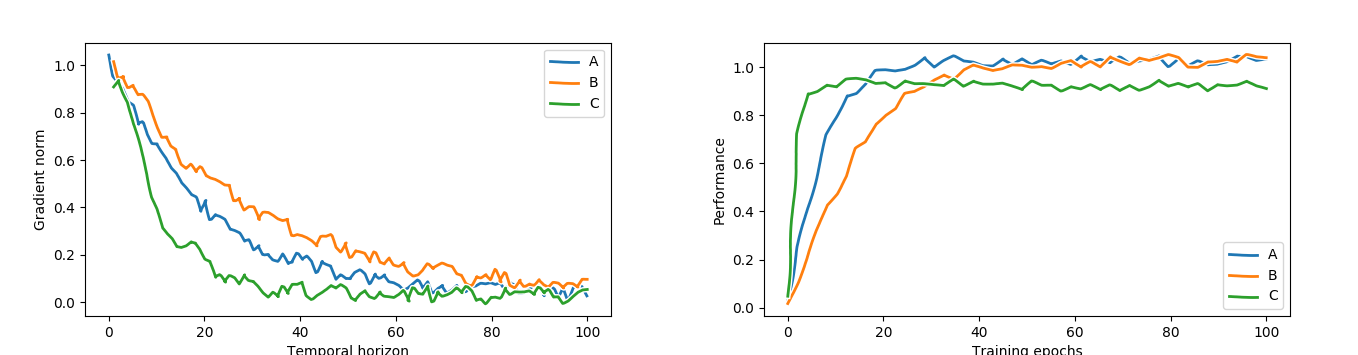

In [0]:
from IPython.display import Image, display
display(Image(filename='question_figs.png', width=850))

* Your answers here.\

If we look at the gradient norm we can see that the gradients of model C decreases more dramatically compared to model A and B, model C also has the worst performance in the three models. With these information we can infer that model C is the basic RNN. \
Both LSTM and GRU uses some kind of control and forget gates to deal with the gradient vanishing problem, thus their gradients doesn't vanish as fast as the basic RNN. To distinguish between these two, we look at the performance plot with respect to the trainging epochs. We see that model B takes longer to train to achieve similar performance as model A, thus we conclude that model B should be the LSTM network and model A should be the GRU network. Here we make the following conclusion:
  * model A -> GRU
  * model B -> LSTM
  * model C -> RNN

As for choosing between these models, we use RNN when the problem is simple and does not include long time series inputs. With more complicated models we would use either the GRU or LSTM. If time constraint is an issue, we may choose the GRU since it trains faster. If we have enough data and computation resources we can use the LSTM since it contains more parameters and would be more powerful compared to the GRU.

c.  Write down five possible Connectionist Temporal Classification (CTC) paths (of no more than a length of eight) that correspond to the same label "LADDER". (10%)

* Your answer here.
### Here we construct 5 possible CTC paths for the label "LADDER"
1. $$
LAD\varnothing DER
$$
2. $$
LAAD\varnothing DER
$$
3. $$
LLAD\varnothing DER
$$
4. $$
LAD\varnothing DERR
$$
5. $$
LAD\varnothing DEER
$$